# ML Week 4 Assignment 

Stan Lyubarskiy

## Instructions

The programming assignment for the Support Vector Machine model is


1. Using the Scikit-Learn Library train the SVM model on the KDD99 data set to classify Dos vs Non Dos using all of the features at once.


2. Run the SVM model (at least) four times using a different kernel each time using all the features.

Compare the results for each of the kernels.
Discuss the pros and cons of using each of the kernels that you've chosen.

3. Pick two features which you think are important for this problem. Train SVM model using only those two features and visualize the decision boundary. Do this for linear kernel and RBF kernel only. You may want to subsample the training data substantially in order to get a good visualization within a reasonable time. Discuss your observations.

Note: You can use label encoder or one hot encoding for encoding categorical variables.

Note: You can refer to https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html or https://scikit-learn.org/dev/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py for visualization

Note: The dataset given is highly imbalanced, you are required to under sample the majority class to make the dataset balanced( Refer: imblearn.under_sampling.RandomUnderSampler).

Furthermore, It is recommended to take a smaller fraction of dataset as SVM is slower compared to other models. Scaling of the dataset could also help (Refer: sklearn.preprocessing.MinMaxScaler).

Different attack types in the dataset:

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2

## Introduction

In this analysis, we will use the same kddcup dataset but for a different use case. We will classify whether the attack is a DoS or non-DoS attack using Support Vector Machines (SVMs). We will begin by importing our libraries and reading in the data. After that we apply filtering, assign our X and Y, transform our features with one hot encoding and standardization before undersampling the dataset. Finally, we split our data into training and testing datasets and begin applying SVM.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

In [2]:
#import the file as a df and the column headers from the names file

df = pd.read_csv("kddcup.data.gz", header=None, names=["duration","protocol_type","service","flag","src_bytes","dst_bytes",
                                                      "land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
                                                      "num_compromised","root_shell","su_attempted","num_root",
                                                      "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
                                                      "is_host_login","is_guest_login","count","srv_count","serror_rate",
                                                      "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
                                                      "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                                                      "dst_host_same_srv_rate","dst_host_diff_srv_rate",
                                                      "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
                                                      "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                                                      "dst_host_srv_rerror_rate","attacks"])

In [3]:
#filter all rows where the attack = normal because we only want attack data in our dataset
df2 = df[df["attacks"] != "normal."]

In [4]:
# let's reset the index so it does not look out of order
df2.reset_index(drop=True, inplace=True)

In [5]:
# check to make sure it worked
print(df2.shape)
df2.head()

(3925650, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attacks
0,184,tcp,telnet,SF,1511,2957,0,0,0,3,...,3,1.00,0.00,1.00,0.67,0.0,0.0,0.0,0.0,buffer_overflow.
1,305,tcp,telnet,SF,1735,2766,0,0,0,3,...,4,1.00,0.00,0.50,0.50,0.0,0.0,0.0,0.0,buffer_overflow.
2,79,tcp,telnet,SF,281,1301,0,0,0,2,...,10,1.00,0.00,1.00,0.30,0.0,0.0,0.0,0.1,loadmodule.
3,25,tcp,telnet,SF,269,2333,0,0,0,0,...,2,0.03,0.06,0.01,0.00,0.0,0.0,0.0,0.0,perl.
4,0,tcp,telnet,S0,0,0,0,0,0,0,...,2,1.00,0.00,1.00,1.00,1.0,0.5,0.0,0.0,neptune.


In [6]:
# assign my y and X
# DoS attacks are "back.", "land.", "neptune.", "pod.", smurf.", "teardrop."
y = df2.iloc[:, -1].values
y = np.where((y == "back.") | (y == "land.") | (y == "neptune.") | (y =="pod.") | (y =="smurf.") | (y =="teardrop."), 1, 0)

X = df2.iloc[:,0:41]

In [7]:
# count of unique Y values
np.unique(y, return_counts=True)

(array([0, 1]), array([  42280, 3883370], dtype=int64))

In [8]:
# use pd.get_dummies to one hot encode all the categorical columns

X = pd.get_dummies(X, prefix="enc")
print(X.columns, X.shape)

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'enc_REJ', 'enc_RSTO', 'enc_RSTOS0', 'enc_RSTR', 'enc_S0', 'enc_S1',
       'enc_S2', 'enc_S3', 'enc_SF', 'enc_SH'],
      dtype='object', length=118) (3925650, 118)


In [9]:
# save the column names for later use
feature_names = X.columns

In [10]:
# standardize the columns with a large variance
# duration, src_bytes, dst_bytes, count, srv_count, dst_host_count, and dst_host_srv_count all have a very large varaince
# we know this from the previous assignment

std_features = ["duration", "src_bytes", "dst_bytes", "count", "srv_count", "dst_host_count", "dst_host_srv_count"]

mms = MinMaxScaler()

X_mms = X.loc[:, std_features].values

X.loc[:, std_features] = mms.fit_transform(X_mms)

In [11]:
#undersample the data
rus = RandomUnderSampler(random_state=0)

X_res, y_res = rus.fit_resample(X, y)

In [12]:
# check the results of undersampling
print("Size of X:",X_res.shape, "Size of Y:", y_res.shape)

Size of X: (84560, 118) Size of Y: (84560,)


In [13]:
# split the data into an 80/20 training/testing division
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=0)

In [14]:
# Size of each sample
print("Size of X_train:",X_train.shape, "Size of Y_train:", y_train.shape)
print("Size of X_test:",X_test.shape, "Size of Y_test:", y_test.shape)

Size of X_train: (67648, 118) Size of Y_train: (67648,)
Size of X_test: (16912, 118) Size of Y_test: (16912,)


For our analysis, we will test the accuracy of the models with four different kernels. The four kernals are linear, poly, rbf, and sigmoid.

## Testing using the Linear Kernel

In [15]:
# Create a linear support vector classifier
svclinear = svm.SVC(kernel="linear")

In [16]:
# fit the model on the training data and time the execution
%timeit svclinear.fit(X_train,y_train)
svclinear.fit(X_train,y_train)

1.63 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


SVC(kernel='linear')

In [17]:
# gather our predictions
linear_pred = svclinear.predict(X_test)

In [19]:
# Print our training and testing accuracy scores for the linear model
print("Training Accuracy:", svclinear.score(X_train, y_train)*100,"%")
print("Testing Accuracy:", (accuracy_score(linear_pred, y_test)*100),"%")
print("Number of Iterations:", svclinear.n_iter_[0])

Training Accuracy: 99.99704351939451 %
Testing Accuracy: 99.98817407757805 %
Number of Iterations: 648


In [86]:
# Look at the size of the support vectors
S = svclinear.support_vectors_
S.shape

(94, 118)

## Observation

The support vector classifier using the linear kernel was very fast and accurate. It produced a ~ 99.99% testing accuracy. Interestingly, only 94 of the 67,648 training samples were used. That seems like a fairly low number but might explain why the computations were so fast. Let us now try the rbf kernel.

## Testing using the RBF Kernel

In [87]:
# create the classifier
svcrbf = svm.SVC(kernel="rbf")

In [88]:
# fit the model on the training data and time the execution
%timeit svcrbf.fit(X_train,y_train)
svcrbf.fit(X_train,y_train)

3.62 s ± 884 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


SVC()

In [92]:
# gather our predictions
rbf_pred = svcrbf.predict(X_test)

In [93]:
# Print our training and testing accuracy scores for the rbf model
print("Training Accuracy:", svcrbf.score(X_train, y_train)*100,"%")
print("Testing Accuracy:", (accuracy_score(rbf_pred, y_test)*100),"%")
print("Number of Iterations:", svcrbf.n_iter_[0])

Training Accuracy: 99.99852175969725 %
Testing Accuracy: 99.99408703878902 %
Number of Iterations: 374


In [94]:
# Look at the size of the support vectors
S2 = svcrbf.support_vectors_
S2.shape

(242, 118)

## Observation

The rbf kernel had even higher testing accuracy than the linear kernel. We also see that it used more support vectors than the linear model. That may have slowed the computation down a bit but it was not very noticeable.

## Testing using the Poly Kernel

In [95]:
# create the classifier
svcpoly = svm.SVC(kernel="poly")

In [96]:
# fit the model on the training data and time the execution
%timeit svcpoly.fit(X_train,y_train)
svcpoly.fit(X_train,y_train)

6.5 s ± 769 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


SVC(kernel='poly')

In [97]:
# gather our predictions
poly_pred = svcpoly.predict(X_test)

In [98]:
# Print our training and testing accuracy scores for the poly model
print("Training Accuracy:", svcpoly.score(X_train, y_train)*100,"%")
print("Testing Accuracy:", (accuracy_score(poly_pred, y_test)*100),"%")
print("Number of Iterations:", svcpoly.n_iter_[0])

Training Accuracy: 99.99556527909176 %
Testing Accuracy: 99.99408703878902 %
Number of Iterations: 458


In [99]:
# Look at the size of the support vectors
S3 = svcpoly.support_vectors_
S3.shape

(302, 118)

### Observation

While slower than the previous two kernels, the polynomial kernal provided the same high accuracy as the rbf kernal. It did this using slightly more support vectors than rbf (302 vs 242, respectively). We timed our code using the magic command timeit. This allowed us to capture each kernel's execution time for the fit method.

## Testing using the Sigmoid Kernal

In [100]:
# create the classifier
svcsigmoid = svm.SVC(kernel="sigmoid")

In [101]:
# fit the model on the training data and time the execution
%timeit svcsigmoid.fit(X_train,y_train)
svcsigmoid.fit(X_train,y_train)

18 s ± 7.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


SVC(kernel='sigmoid')

In [102]:
# gather our predictions
sigmoid_pred = svcsigmoid.predict(X_test)

In [103]:
# Print our training and testing accuracy scores for the poly model
print("Training Accuracy:", svcsigmoid.score(X_train, y_train)*100,"%")
print("Testing Accuracy:", (accuracy_score(sigmoid_pred, y_test)*100),"%")
print("Number of Iterations:", svcsigmoid.n_iter_[0])

Training Accuracy: 99.87287133396406 %
Testing Accuracy: 99.85808893093662 %
Number of Iterations: 687


In [104]:
# Look at the size of the support vectors
S4 = svcsigmoid.support_vectors_
S4.shape

(494, 118)

## Observation

Out of the four kernels tested, sigmoid performed the worst in accuracy at 99.86%. It needed the highest number of iterations to converge and was the slowest to compute the fit. It also required the most support vectors of the four models at 494. 

## Pros and Cons of Different Kernels

Generally speaking, the linear kernel is the fastest of the four kernels. It is best suited for linearly separable classification problems and works very well when there are a lot of features. The polynomial kernel is a generalized version of the linear kernel that is usually less efficient and less accurate. The Gaussian Radial Basis Function (RBF) is the most frequently used of the four kernels. It is well-suited for non-linear classification problems. Finally, the sigmoid kernel is mostly used for neural networks.

More specific to the results shown in this analysis, we found sigmoid to be the slowest and most inaccurate kernel for our dataset. Both RBF and the polynomial performed the best in terms of accuracy reaching ~ 99.99%. The linear kernel was by far the fastest but had the second lowest accuracy.

Each of these kernels have their benefits and disadvantages. However, the most important indicator is whether they are appropriate for a specific use case. The linear kernel is fast, simple, and scalable. It will work marvelously for linearly separable data. Conversly, RBF can work for both linear and non-linear data. Given a choice between the two, the linear kernel is prefered for linearly separable data. If the data is non-linear, then RBF is an excellent choice and recommended. It projects the data to a higher dimensional space where it can identify a linear separation between the data. This works well but at a cost of computational intensity and complexity. Therefore, RBF has a harder time when there are a lot of features because of the expensive transformations and computations that it performs. In conclusion, the linear kernel should be used for linear problems and RBF for non-linear in most cases.

## Plotting the Decision Boundary for Two Important Features

We will take a look at the absolute coefficients for the linear kernels to identify the top two features. While these do not mean exactly the same things as they do for logistic regressions, it is still informative for the linear kernel. Based on our previous analysis using the linear kernel and our own security knowledge, we believe that dst_host_serror_rate and diff_srv_rate are the two most important features for this dataset.

In [147]:
# top features for the linear kernel

# map feature names to coeff in a df
linear_coef = pd.DataFrame(data=abs(svclinear.coef_),columns=feature_names)
# transpose the df for better readibility
linear_coef = linear_coef.T
linear_coef.rename(columns={0:"Features"},inplace=True)
# sort by top coeff values
top_linear = linear_coef.sort_values(by="Features",ascending=False).head(10)
top_linear

,Features
dst_host_serror_rate,3.141208
diff_srv_rate,2.481120
dst_host_rerror_rate,2.368341
dst_host_same_src_port_rate,1.873802
dst_host_diff_srv_rate,1.702648
wrong_fragment,1.632877
enc_ecr_i,1.623692
dst_host_srv_count,1.506968
dst_host_srv_serror_rate,1.411456
num_failed_logins,1.322999


In [106]:
# Assign new X and Y variables for the decision boundary

y2 = df2.iloc[:, -1].values
y2 = np.where((y2 == "back.") | (y2 == "land.") | (y2 == "neptune.") | (y2 =="pod.") | 
              (y2 =="smurf.") | (y2 =="teardrop."), 1, 0)
# only grab the two columns we are interest in: dst_host_serror_rate and diff_srv_rate
X2 = df2.loc[:,("dst_host_serror_rate", "diff_srv_rate")]

In [107]:
# undersample the data with only two features
rus2 = RandomUnderSampler(random_state=0)

X_res2, y_res2 = rus2.fit_resample(X2, y2)

In [108]:
# split the data into an 80/20 training/testing division
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_res2, y_res2, test_size=0.20, random_state=0)

In [109]:
# Size of each sample
print("Size of X_train2:",X_train2.shape, "Size of Y_train2:", y_train2.shape)
print("Size of X_test2:",X_test2.shape, "Size of Y_test2:", y_test2.shape)

Size of X_train2: (67648, 2) Size of Y_train2: (67648,)
Size of X_test2: (16912, 2) Size of Y_test2: (16912,)


In [110]:
decision_features = X_train2.columns
decision_features

Index(['dst_host_serror_rate', 'diff_srv_rate'], dtype='object')

In [111]:
# Turn the training data into ndarrays for plotting
X_train2 = X_train2.values

In [141]:
# we create an instance of SVM and fit our data
svc_linear = svm.SVC(kernel='linear').fit(X_train2, y_train2)
rbf_svc = svm.SVC(kernel='rbf').fit(X_train2, y_train2)

In [142]:
# test accuracy of the two features
print("Linear\n","Train:",svc_linear.score(X_train2, y_train2),"Test:",svc_linear.score(X_test2.values, y_test2))

Linear
 Train: 0.7050023651844843 Test: 0.7076631977294229


In [143]:
print("RBF\n","Train:",rbf_svc.score(X_train2, y_train2),"Test:",rbf_svc.score(X_test2.values, y_test2))

RBF
 Train: 0.7262446783349101 Test: 0.7317289498580889


### Observation

After fitting the linear and RBF kernels with the training data, we can see the accuracy scores. Despite using the top two features by highest linear coefficients, we see that the accuracy hovers around 70 percent which is comparatively low to the previous kernels with all features. This makes sense given that the weights were relatively even among the top 10 features so using only two of them should not yield very high accuracy.

Next we will plot these two features to see the decision boundary.

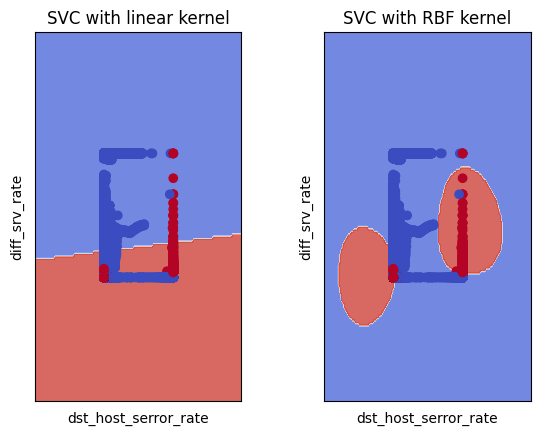

In [112]:
# visualize the decision boundary using the two features

h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train2[:, 0].min() - 1, X_train2[:, 0].max() + 1
y_min, y_max = X_train2[:, 1].min() - 1, X_train2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel']

for i, clf in enumerate((svc_linear, rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_train2[:,0], X_train2[:, 1], c=y_train2, cmap=plt.cm.coolwarm)
    plt.xlabel(decision_features[0])
    plt.ylabel(decision_features[1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Observation

The decision boundary for both kernels takes an interesting shape. These two features do not appear to be linearly separable so a line drawn between them cannot classify all of them correctly. The red dots appear to be primarily wrong for the left plot. The plot on the right for the RBF implies that most of the blue was classified correctly and a good chunk of the red was also captured with the ovals. This highly non-linear approach seems to predict better. We see that manifested in the accuracy scores. However, we would have expected RBF to produce a much higher score given the visualization. Let us try two different features to see what happens.

Let us take two of the worst non-zero features by linear coefficient. We end up with dst_bytes and src_bytes.

In [129]:
# map feature names to coeff in a df
linear_coef2 = pd.DataFrame(data=abs(svclinear.coef_),columns=feature_names)
# transpose the df for better readibility
linear_coef2 = linear_coef2.T
linear_coef2.rename(columns={0:"Features"},inplace=True)
# sort by lowest coeff values
worst_linear = linear_coef.sort_values(by="Features").head(60)
worst_linear

,Features
enc_exec,0.000000
enc_nntp,0.000000
enc_netstat,0.000000
enc_netbios_ns,0.000000
enc_netbios_dgm,0.000000
enc_name,0.000000
enc_mtp,0.000000
enc_login,0.000000
enc_ldap,0.000000
enc_klogin,0.000000


In [130]:
# Assign new X and Y variables for the decision boundary

y3 = df2.iloc[:, -1].values
y3 = np.where((y3 == "back.") | (y3 == "land.") | (y3 == "neptune.") | (y3 =="pod.") | 
              (y3 =="smurf.") | (y3 =="teardrop."), 1, 0)
# only grab the two columns we are interest in: dst_host_serror_rate and diff_srv_rate
X3 = df2.loc[:,("dst_bytes", "src_bytes")]

In [131]:
# We know that these two columns have a large variance so let's standardize them

mms2 = MinMaxScaler()

X3.iloc[:, :] = mms2.fit_transform(X3.values)

In [132]:
# undersample the data with only two features
rus3 = RandomUnderSampler(random_state=0)

X_res3, y_res3 = rus3.fit_resample(X3, y3)

In [133]:
# split the data into an 80/20 training/testing division
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_res3, y_res3, test_size=0.20, random_state=0)

In [134]:
# Size of each sample
print("Size of X_train3:",X_train3.shape, "Size of Y_train3:", y_train3.shape)
print("Size of X_test3:",X_test3.shape, "Size of Y_test3:", y_test3.shape)

Size of X_train3: (67648, 2) Size of Y_train3: (67648,)
Size of X_test3: (16912, 2) Size of Y_test3: (16912,)


In [135]:
# save the feature names for plotting
decision_features2 = X_train3.columns
decision_features2

Index(['dst_bytes', 'src_bytes'], dtype='object')

In [136]:
# Turn the training data into ndarrays for plotting
X_train3 = X_train3.values

In [137]:
# we create an instance of SVM and fit our data
svc_linear2 = svm.SVC(kernel='linear').fit(X_train3, y_train3)
rbf_svc2 = svm.SVC(kernel='rbf').fit(X_train3, y_train3)

In [138]:
# test accuracy of the two features
print("Linear2\n","Train:",svc_linear2.score(X_train3, y_train3),"Test:",svc_linear.score(X_test3.values, y_test3))

Linear2
 Train: 0.5019808420056765 Test: 0.5080416272469253


In [139]:
print("RBF2\n","Train:",rbf_svc2.score(X_train3, y_train3),"Test:",rbf_svc.score(X_test3.values, y_test3))

RBF2
 Train: 0.5019808420056765 Test: 0.508100756859035


## Observation

As expected, choosing such low weighted features did not result in an improvement in model accuracy. In fact, it drastically decreased. Therefore, it appears that the original two features that were chosen may have been the correct ones. Let us try to plot the decision boundary with these two features to compare the shape to our previous example.

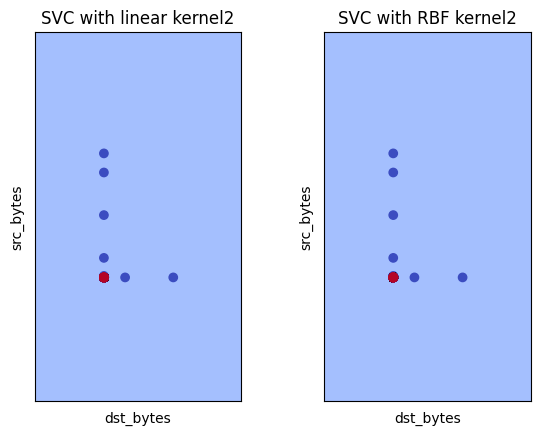

In [140]:
# visualize the decision boundary using the two lower performing features

h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = X_train3[:, 0].min() - 1, X_train3[:, 0].max() + 1
y_min, y_max = X_train3[:, 1].min() - 1, X_train3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel2',
          'SVC with RBF kernel2']

for i, clf in enumerate((svc_linear2, rbf_svc2)):
    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X_train3[:,0], X_train3[:, 1], c=y_train3, cmap=plt.cm.coolwarm)
    plt.xlabel(decision_features2[0])
    plt.ylabel(decision_features2[1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

## Observation

The inability to draw a decision boundary by either kernel is expected. We saw previously that the accuracy was no better than a random coin flip. Here we can observe visually that these two features are very poor predictors of our classification. This supports our theory that the previous two features were the best predictors. To truly test that theory, we would need to test every combination of features. However, given the computational intensity and workload, it is beyond the scope of this analysis.

# Summary

This has been an exciting exploration into Support Vector Machines (SVM). The different kernel options allow them to be adaptable to different problems. It works for both linear and non-linear binary classification use cases. After working with logistic regression, SVM presents an entirely different approach to classification. It separates the two classes into separate categories and tries to maximize the space between them. If the problem is non-linear, SVM uses a "kernel trick" to map the points to a higher dimension where a linear separation can be made.

For our dataset, RBF and poly were the most accurate kernels. The linear kernel was the fastest to converge while sigmoid was the worst performer. We used the coefficients and weights from the linear kernel to identify the two most important features. We then plotted them on a decision boundary. The result was unexpected as the RBF kernel's decision boundary appeared very accurate but the actual accuracy was mariginally better than that of the linear kernel.

To test our methodology, we chose the two worst features with non-zero weights. This produced a roughly 50 percent accuracy. The decision boundary could not even be drawn for that exercise. We took this to mean that our original choice of top two features was best. Given the roughly proportional feature weights across dozens of features, it is likely that any two feature combination would not yield accuracy of 90 percent.